In [69]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/grenhouse.csv")

# Show the first few rows
df.head()


,timestamp,temperature_c,humidity_percent,high_temp_status
0,2023-01-01 00:00:00,24.1,83.34,0
1,2023-01-01 01:00:00,23.1,88.52,1
2,2023-01-01 02:00:00,23.6,79.89,0
3,2023-01-01 03:00:00,22.1,94.06,1
4,2023-01-01 04:00:00,21.1,100.00,1


# New section

In [70]:
print(df.isnull().sum())

timestamp           0
temperature_c       0
humidity_percent    0
high_temp_status    0
dtype: int64


In [71]:
df = df.drop(columns=["timestamp"])


In [72]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['temperature_c', 'humidity_percent']] = scaler.fit_transform(df[['temperature_c', 'humidity_percent']])


In [73]:
X = df[['temperature_c', 'humidity_percent']].values
y = df['high_temp_status'].values


In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [75]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(2,)),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=400, validation_data=(X_test, y_test))

Epoch 1/400


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5307 - loss: 0.6839 - val_accuracy: 0.5535 - val_loss: 0.6282
Epoch 2/400
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6508 - loss: 0.5993 - val_accuracy: 0.8183 - val_loss: 0.4782
Epoch 3/400
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8712 - loss: 0.4394 - val_accuracy: 0.8807 - val_loss: 0.3286
Epoch 4/400
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8992 - loss: 0.3071 - val_accuracy: 0.9118 - val_loss: 0.2659
Epoch 5/400
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9020 - loss: 0.2554 - val_accuracy: 0.9093 - val_loss: 0.2324
Epoch 6/400
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9128 - loss: 0.2323 - val_accuracy: 0.9175 - val_loss: 0.2069
Epoch 7/400
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9249 - loss: 0.2010 - val_accuracy: 0.9355 - val_loss: 0.1848
Epoch 8/400
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9394 - loss: 0.1793 - val_accuracy: 0.9387

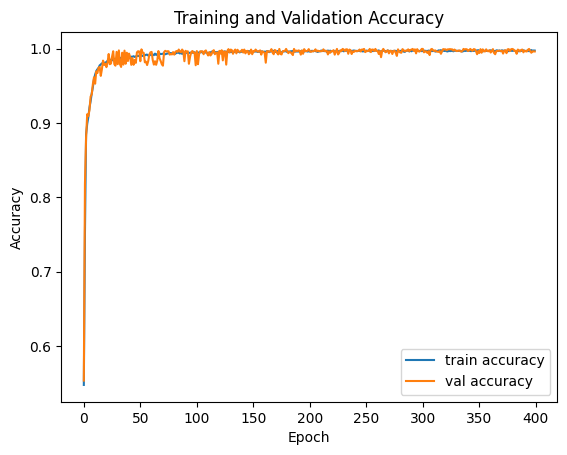

In [76]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

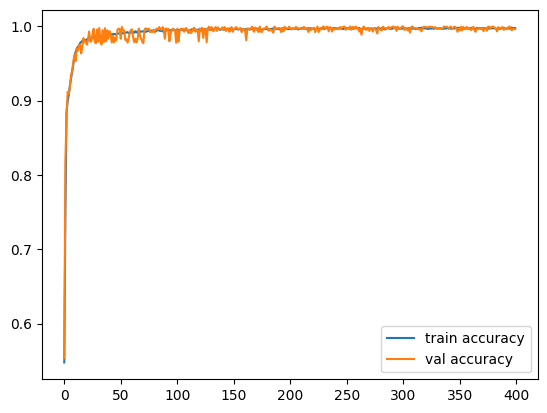

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[[1555   10]
 [   3 1937]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1565
           1       0.99      1.00      1.00      1940

    accuracy                           1.00      3505
   macro avg       1.00      1.00      1.00      3505
weighted avg       1.00      1.00      1.00      3505



In [77]:
import matplotlib.pyplot as plt

# Accuracy and loss plot
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

# Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [78]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('greenhouse_model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpdg7fspyv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2), dtype=tf.float32, name='keras_tensor_32')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133094327811728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133094327796368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133094327806160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133094327804624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133094327802128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133094327811152: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [79]:
interpreter = tf.lite.Interpreter(model_path="greenhouse_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

sample_input = np.array([[0.7, 0.3]], dtype=np.float32)  # Example input
interpreter.set_tensor(input_details[0]['index'], sample_input)
interpreter.invoke()
prediction = interpreter.get_tensor(output_details[0]['index'])
print("Fan ON" if prediction[0][0] > 0.5 else "Fan OFF")


Fan ON


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [80]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0068
Test Loss: 0.0079
Test Accuracy: 0.9963


In [81]:
import numpy as np

def predict_fan_status(temperature, humidity, scaler, interpreter, input_details, output_details):
    # Scale the input data
    scaled_input = scaler.transform(np.array([[temperature, humidity]]))

    # Set the tensor for the TFLite interpreter
    interpreter.set_tensor(input_details[0]['index'], scaled_input.astype(np.float32))

    # Invoke the interpreter
    interpreter.invoke()

    # Get the output tensor
    prediction = interpreter.get_tensor(output_details[0]['index'])

    # Determine fan status based on the prediction
    return "Fan ON" if prediction[0][0] > 0.5 else "Fan OFF"

# Example usage:
sample_temperature = 35.0
sample_humidity = 80.0

fan_status = predict_fan_status(sample_temperature, sample_humidity, scaler, interpreter, input_details, output_details)
print(f"For Temperature: {sample_temperature}°C and Humidity: {sample_humidity}%, the fan is: {fan_status}")

For Temperature: 35.0°C and Humidity: 80.0%, the fan is: Fan ON


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [86]:
import numpy as np
import tensorflow as tf

# Load the converted TFLite model
interpreter = tf.lite.Interpreter(model_path="greenhouse_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Helper function to make prediction
def predict_fan_status(temp, humidity):
    # Normalize the input using the same scaler
    input_data = scaler.transform([[temp, humidity]]).astype(np.float32)

    # Set input and run inference
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    # Get the result
    prediction = interpreter.get_tensor(output_details[0]['index'])[0][0]

    # Interpret result
    status = "ON" if prediction > 0.5 else "OFF"
    print(f"🌡️ Temp: {temp}°C, 💧 Humidity: {humidity}% → 🌀 Fan: {status} (Confidence: {prediction:.2f})")

# Test examples
predict_fan_status(35, 80)  # Very hot & humid
predict_fan_status(22, 50)  # Cool & dry
predict_fan_status(28, 90)  # Warm & humid
predict_fan_status(30, 40)  # Hot but dry


🌡️ Temp: 35°C, 💧 Humidity: 80% → 🌀 Fan: ON (Confidence: 1.00)
🌡️ Temp: 22°C, 💧 Humidity: 50% → 🌀 Fan: OFF (Confidence: 0.00)
🌡️ Temp: 28°C, 💧 Humidity: 90% → 🌀 Fan: ON (Confidence: 1.00)
🌡️ Temp: 30°C, 💧 Humidity: 40% → 🌀 Fan: OFF (Confidence: 0.00)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packa

In [83]:
print("mins:", scaler.data_min_)  # [temp_min, hum_min]
print("maxs:", scaler.data_max_)  # [temp_max, hum_max]


mins: [20.9  31.69]
maxs: [ 90.5 100. ]
